In [8]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.append('/mloscratch/homes/yixuan/PDM')

In [20]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from utils.edit_distance import compute_ngram_distance_damerau_levenshtein
from utils.LCS import find_longest_common_substrings
from utils.comon_substring import CommonSubstringMatcher

In [13]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

def get_checkpoints(expr_base_dir):
    """
    Get sorted checkpoints from directory
    
    Parameters
    ----------
    expr_base_dir : str
        Base directory containing checkpoints
        
    Returns
    -------
    list
        Sorted list of (step, consumed) tuples
    """
    return sorted([(int(f.name.split('=')[1].split('-')[0]), int(f.name.split('=')[2]))
                  for f in Path(expr_base_dir).glob("step=*")])

def load_inference_data(base_dir, step, consumed):
    """
    Load inference data from a given step
    
    Parameters
    ----------
    base_dir : str
        Base directory path
    step : int
        Training step
    consumed : int
        Number of consumed tokens
        
    Returns
    -------
    Dataset
        HuggingFace dataset containing inference results
    """
    file_path = f"{base_dir}/step={step}-consumed={consumed}"
    return load_dataset('json', data_files=f"{file_path}/rank*.jsonl", split='train')

def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            lcs_res = find_longest_common_substrings(data['true_suffix'], data['generated_suffix'])
            steps.append(step)
            avg_lengths.append(lcs_res.max_length.mean())
            
        results[model_id] = {'steps': steps, 'avg_lengths': avg_lengths}
    
    return results

In [14]:
def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate LCS for each split
            lcs_results = {}
            for split_name, split_data in splits.items():
                lcs_res = find_longest_common_substrings(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                lcs_results[split_name] = lcs_res.max_length.mean()
            
            steps.append(step)
            avg_lengths.append(lcs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [15]:
def plot_comparison(results, exclude_models=None, exclude_splits=None):
    """
    Plot comparison of models with train/val/test splits
    
    Parameters
    ----------
    results : dict
        Dictionary containing results for each model and split
    exclude_models : list, optional
        List of model IDs to exclude from plotting
    exclude_splits : list, optional
        List of split names to exclude from plotting
    """
    plt.figure(figsize=(12, 6))
    
    # Line styles for different splits
    styles = {
        'train': '-',
        'val': '--',
        'test': ':'
    }
    
    # Filter out excluded splits
    if exclude_splits:
        styles = {k: v for k, v in styles.items() if k not in exclude_splits}
    
    # Filter out excluded models and plot remaining ones
    for model_name, model_results in results.items():
        if exclude_models and model_name in exclude_models:
            continue
            
        # Plot each split with different line style
        for split_name, style in styles.items():
            split_data = model_results[split_name]

            # Convert steps to epochs
            epochs = [step/75 for step in split_data['steps']]

            plt.plot(epochs, split_data['avg_lengths'],
                    linestyle=style,
                    marker='o', 
                    label=f'{model_name} ({split_name})',
                    alpha=0.7)
    
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Memorisation Length')
    plt.title('Average Longest Verbatim Memorisation Length vs Training Steps')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

In [8]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]
results = calc_avg_lcs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   4%|▍         | 1/23 [00:17<06:21, 17.35s/it]

Time taken: 1.36 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   9%|▊         | 2/23 [00:34<05:56, 16.98s/it]

Time taken: 1.38 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  13%|█▎        | 3/23 [00:50<05:34, 16.71s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  17%|█▋        | 4/23 [01:07<05:16, 16.67s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  22%|██▏       | 5/23 [01:23<04:59, 16.66s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  26%|██▌       | 6/23 [01:40<04:43, 16.67s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  30%|███       | 7/23 [01:56<04:24, 16.55s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  35%|███▍      | 8/23 [02:13<04:08, 16.53s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  39%|███▉      | 9/23 [02:29<03:51, 16.55s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  43%|████▎     | 10/23 [02:46<03:34, 16.47s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  48%|████▊     | 11/23 [03:03<03:19, 16.61s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  52%|█████▏    | 12/23 [03:19<03:01, 16.51s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  57%|█████▋    | 13/23 [03:35<02:44, 16.50s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  61%|██████    | 14/23 [03:52<02:27, 16.44s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  65%|██████▌   | 15/23 [04:08<02:11, 16.47s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  70%|██████▉   | 16/23 [04:25<01:56, 16.61s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  74%|███████▍  | 17/23 [04:41<01:38, 16.44s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  78%|███████▊  | 18/23 [04:58<01:22, 16.50s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  83%|████████▎ | 19/23 [05:14<01:05, 16.41s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  87%|████████▋ | 20/23 [05:30<00:49, 16.45s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  91%|█████████▏| 21/23 [05:47<00:32, 16.49s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  96%|█████████▌| 22/23 [06:04<00:16, 16.48s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93: 100%|██████████| 23/23 [06:20<00:00, 16.53s/it]


Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   0%|          | 0/21 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   5%|▍         | 1/21 [00:16<05:24, 16.22s/it]

Time taken: 1.35 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  10%|▉         | 2/21 [00:32<05:09, 16.27s/it]

Time taken: 1.39 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  14%|█▍        | 3/21 [00:48<04:52, 16.23s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  19%|█▉        | 4/21 [01:05<04:39, 16.41s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  24%|██▍       | 5/21 [01:21<04:20, 16.31s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  29%|██▊       | 6/21 [01:37<04:05, 16.36s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  33%|███▎      | 7/21 [01:54<03:47, 16.27s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  38%|███▊      | 8/21 [02:10<03:32, 16.34s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  43%|████▎     | 9/21 [02:26<03:15, 16.32s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  48%|████▊     | 10/21 [02:43<02:59, 16.34s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  52%|█████▏    | 11/21 [02:59<02:43, 16.36s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  57%|█████▋    | 12/21 [03:15<02:26, 16.27s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  62%|██████▏   | 13/21 [03:31<02:09, 16.25s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  67%|██████▋   | 14/21 [03:47<01:53, 16.21s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  71%|███████▏  | 15/21 [04:04<01:38, 16.36s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  76%|███████▌  | 16/21 [04:20<01:21, 16.32s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  81%|████████  | 17/21 [04:37<01:05, 16.49s/it]

Time taken: 1.57 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  86%|████████▌ | 18/21 [04:54<00:49, 16.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  90%|█████████ | 19/21 [05:12<00:33, 16.86s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  95%|█████████▌| 20/21 [05:29<00:17, 17.12s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83: 100%|██████████| 21/21 [05:46<00:00, 16.50s/it]


Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   5%|▌         | 1/19 [00:16<04:57, 16.52s/it]

Time taken: 1.35 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  11%|█         | 2/19 [00:32<04:37, 16.32s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  16%|█▌        | 3/19 [00:49<04:23, 16.46s/it]

Time taken: 1.67 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  21%|██        | 4/19 [01:05<04:07, 16.49s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.10 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  26%|██▋       | 5/19 [01:23<03:55, 16.85s/it]

Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  32%|███▏      | 6/19 [01:40<03:39, 16.88s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  37%|███▋      | 7/19 [01:56<03:20, 16.67s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  42%|████▏     | 8/19 [02:13<03:03, 16.72s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  47%|████▋     | 9/19 [02:29<02:45, 16.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.11 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  53%|█████▎    | 10/19 [02:46<02:30, 16.75s/it]

Time taken: 0.10 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  58%|█████▊    | 11/19 [03:03<02:13, 16.68s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  63%|██████▎   | 12/19 [03:20<01:57, 16.73s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  68%|██████▊   | 13/19 [03:36<01:39, 16.54s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  74%|███████▎  | 14/19 [03:52<01:22, 16.46s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  79%|███████▉  | 15/19 [04:08<01:05, 16.40s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  84%|████████▍ | 16/19 [04:24<00:48, 16.23s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  89%|████████▉ | 17/19 [04:40<00:32, 16.27s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  95%|█████████▍| 18/19 [04:57<00:16, 16.25s/it]

Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79: 100%|██████████| 19/19 [05:13<00:00, 16.52s/it]


Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   5%|▌         | 1/19 [00:17<05:15, 17.51s/it]

Time taken: 1.37 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  11%|█         | 2/19 [00:34<04:50, 17.10s/it]

Time taken: 1.39 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  16%|█▌        | 3/19 [00:51<04:34, 17.16s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  21%|██        | 4/19 [01:08<04:15, 17.00s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.48 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  26%|██▋       | 5/19 [01:25<03:57, 16.97s/it]

Time taken: 0.10 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  32%|███▏      | 6/19 [01:41<03:38, 16.81s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  37%|███▋      | 7/19 [01:58<03:22, 16.87s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.45 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.11 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  42%|████▏     | 8/19 [02:14<03:03, 16.65s/it]

Time taken: 0.11 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  47%|████▋     | 9/19 [02:31<02:46, 16.62s/it]

Time taken: 1.45 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  53%|█████▎    | 10/19 [02:48<02:29, 16.61s/it]

Time taken: 1.58 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  58%|█████▊    | 11/19 [03:04<02:12, 16.58s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  63%|██████▎   | 12/19 [03:21<01:57, 16.83s/it]

Time taken: 1.63 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  68%|██████▊   | 13/19 [03:38<01:39, 16.66s/it]

Time taken: 1.49 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  74%|███████▎  | 14/19 [03:54<01:23, 16.61s/it]

Time taken: 1.63 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  79%|███████▉  | 15/19 [04:10<01:05, 16.49s/it]

Time taken: 1.60 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  84%|████████▍ | 16/19 [04:28<00:50, 16.67s/it]

Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  89%|████████▉ | 17/19 [04:44<00:33, 16.60s/it]

Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  95%|█████████▍| 18/19 [05:00<00:16, 16.51s/it]

Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75: 100%|██████████| 19/19 [05:17<00:00, 16.70s/it]

Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


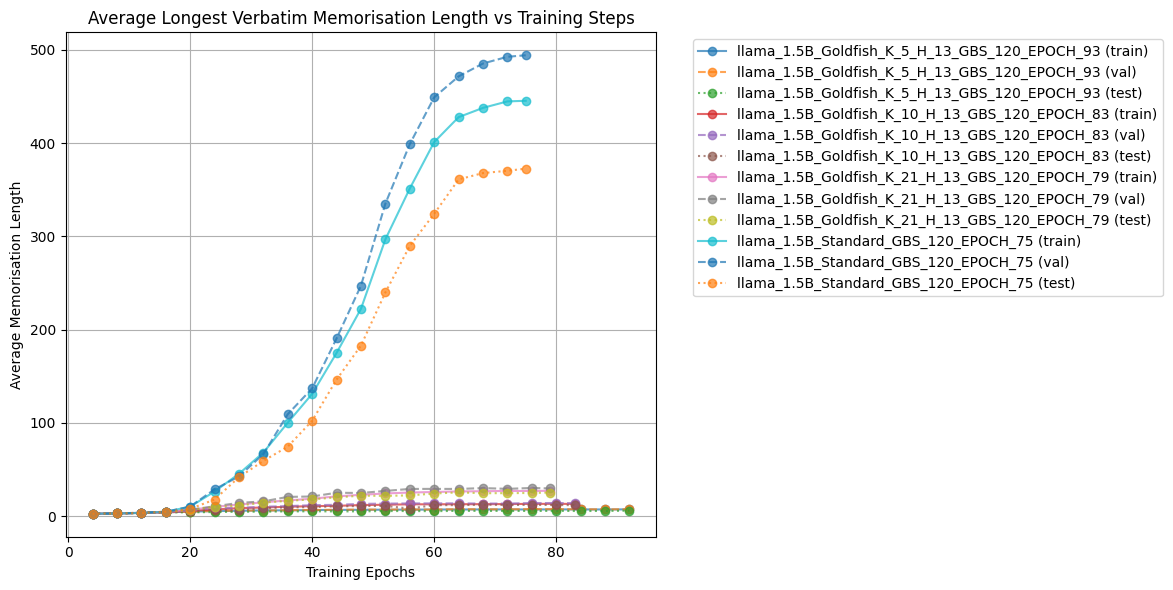

In [11]:
plot_comparison(results)

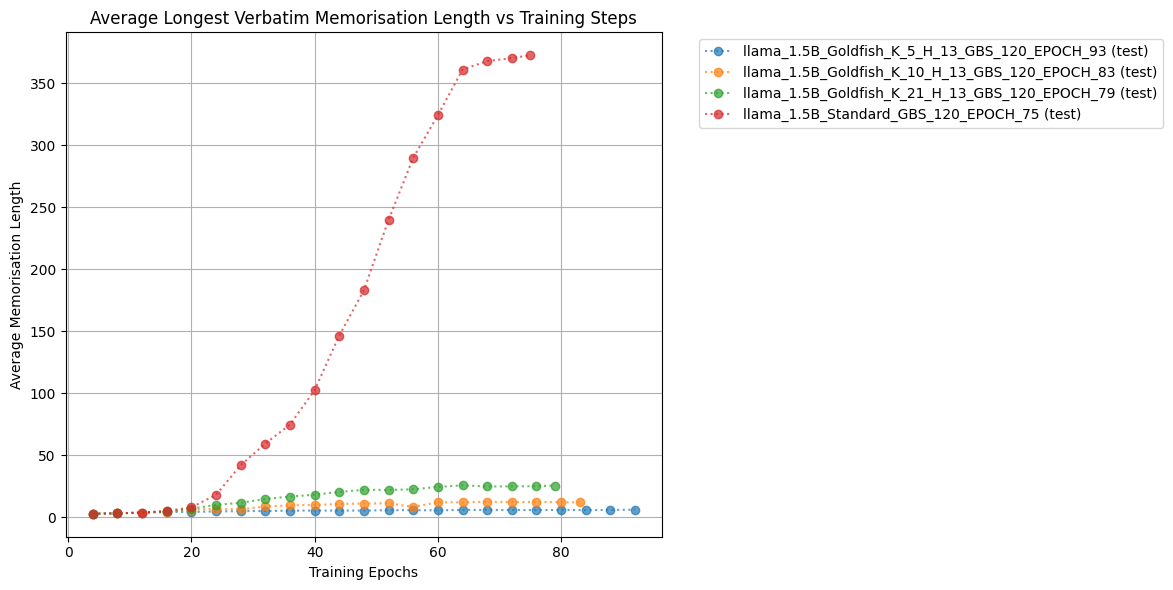

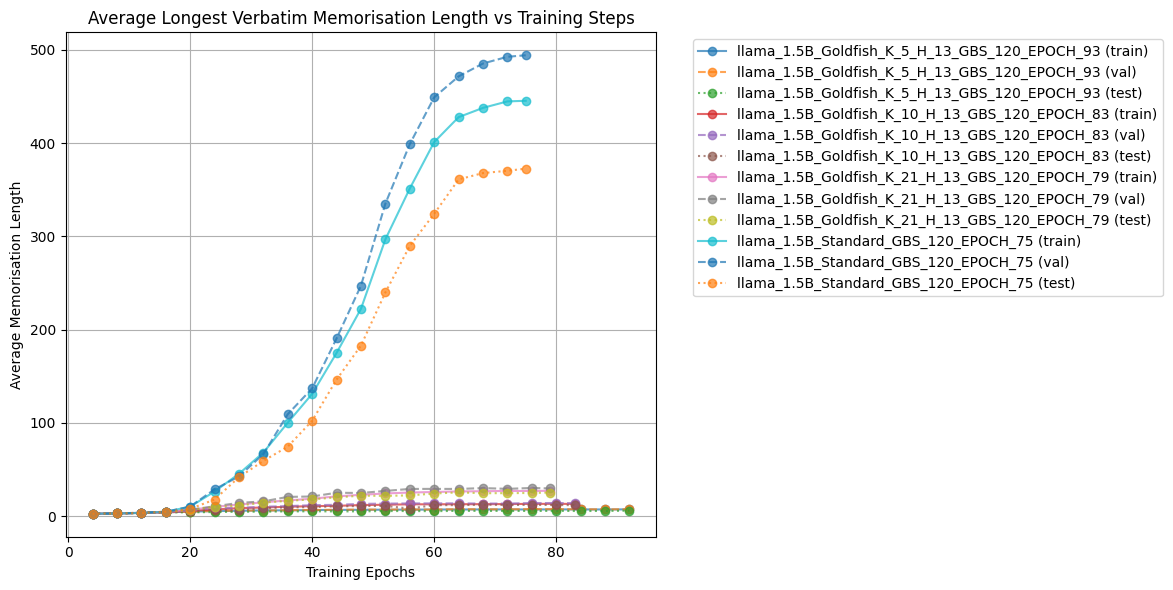

In [ ]:
# Exclude specific models and splits
plot_comparison(results, 
                exclude_splits=['train', 'val'])

In [14]:
results

{'llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93': {'train': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5100,
    5400,
    5700,
    6000,
    6300,
    6600,
    6900],
   'avg_lengths': [2.687333333333333,
    2.9947777777777778,
    3.5816666666666666,
    4.195333333333333,
    4.914555555555555,
    5.520555555555555,
    5.824666666666666,
    6.2155555555555555,
    6.316111111111111,
    6.602555555555556,
    6.744,
    6.886444444444445,
    7.014666666666667,
    7.0472222222222225,
    7.175888888888889,
    7.211555555555556,
    7.283888888888889,
    7.2844444444444445,
    7.25,
    7.315888888888889,
    7.287222222222222,
    7.257666666666666,
    7.3501111111111115]},
  'val': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5

In [27]:
import pickle  # or import json
import os

# Using pickle (better for complex Python objects)
def save_results(results, save_path):
    """
    Save results dictionary to a file
    
    Parameters
    ----------
    results : dict
        Dictionary containing results
    save_path : str
        Path to save the results (e.g., 'results/data.pkl')
    """
    # Create directory if it doesn't exist
    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

In [21]:
pwd

'/mloscratch/homes/yixuan/PDM'

In [22]:
save_results(results, './avg_lcs.pkl')

In [23]:
with open('./avg_lcs.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

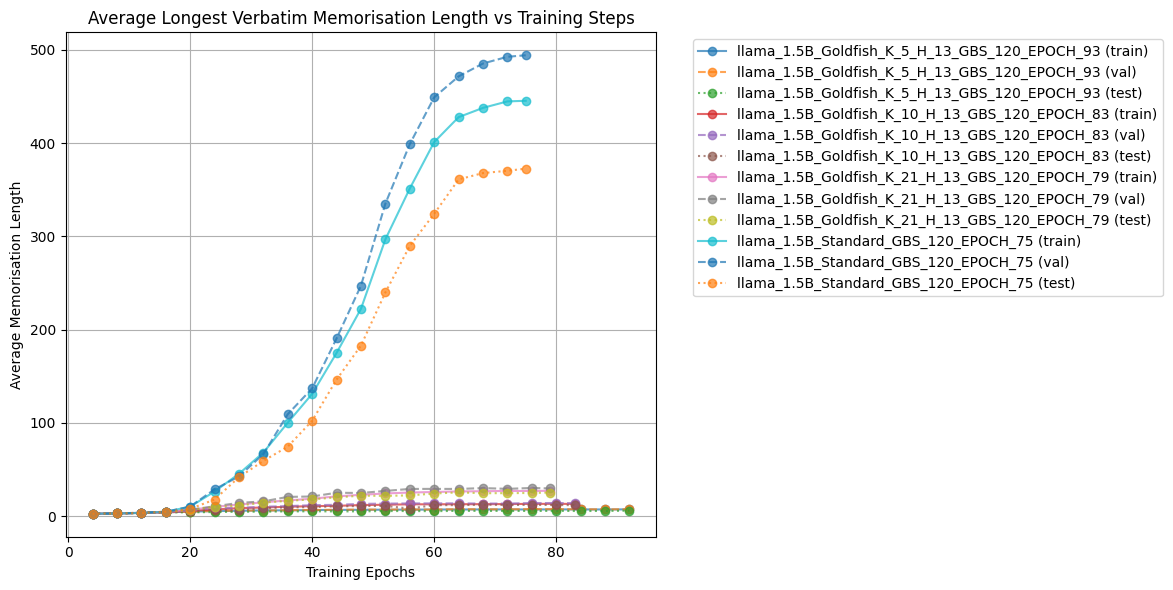

In [24]:
plot_comparison(loaded_results)

In [16]:
def calc_avg_cs_lengths(base_dir, model_ids):
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        checkpoints = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(checkpoints, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            cs_master = CommonSubstringMatcher(data['true_suffix'], data['generated_suffix'])
            matches = cs_master.get_all_matches()
            
            # Using nanmean for samples with all None matches (empty lists)
            avg_length = np.nanmean([np.mean([match.length if match is not None else 0 
                                         for match in sample]) 
                                for sample in matches])
            
            steps.append(step)
            avg_lengths.append(avg_length)
        
        results[model_id] = {'steps': steps, 'avg_lengths': avg_lengths}
    
    return results

In [21]:
def calc_avg_cs_lengths(base_dir, model_ids):
    """
    Calculate average common substring lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate CS for each split
            cs_results = {}
            for split_name, split_data in splits.items():
                cs_master = CommonSubstringMatcher(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                matches = cs_master.get_all_matches()
                # Using nanmean for samples with all None matches
                cs_results[split_name] = np.nanmean([
                    np.mean([match.length if match is not None else 0 for match in sample])
                    for sample in matches
                ])
            
            steps.append(step)
            avg_lengths.append(cs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [22]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]

In [23]:
results = calc_avg_cs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]

Computed DP matrices in 3.19 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:15<00:00, 599.19sequence/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 527.10sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1060.66sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   4%|▍         | 1/23 [00:35<12:55, 35.27s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 834.20sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 539.32sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1070.51sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   9%|▊         | 2/23 [01:03<10:57, 31.33s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 896.63sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1161.42sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1208.36sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  13%|█▎        | 3/23 [01:31<09:50, 29.50s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 939.74sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1236.93sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1325.84sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  17%|█▋        | 4/23 [01:57<08:58, 28.34s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 972.62sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 609.25sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1364.38sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  22%|██▏       | 5/23 [02:24<08:22, 27.92s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1045.69sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1294.07sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1406.29sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  26%|██▌       | 6/23 [02:50<07:39, 27.05s/it]

Computed DP matrices in 0.71 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1008.39sequence/s]


Computed DP matrices in 0.04 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1311.50sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1366.21sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  30%|███       | 7/23 [03:15<07:04, 26.53s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 978.69sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1265.74sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1386.53sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  35%|███▍      | 8/23 [03:41<06:34, 26.29s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1024.72sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 621.58sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1375.02sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  39%|███▉      | 9/23 [04:07<06:05, 26.13s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1031.59sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1234.55sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1366.79sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  43%|████▎     | 10/23 [04:32<05:36, 25.88s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1000.26sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 605.95sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1340.46sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  48%|████▊     | 11/23 [04:58<05:11, 25.96s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1030.50sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1272.05sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1331.23sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  52%|█████▏    | 12/23 [05:24<04:43, 25.80s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1034.47sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 608.36sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1346.90sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  57%|█████▋    | 13/23 [05:50<04:18, 25.84s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1023.42sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1277.13sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1371.89sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  61%|██████    | 14/23 [06:15<03:52, 25.81s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 957.64sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1247.48sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1391.27sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  65%|██████▌   | 15/23 [06:42<03:29, 26.15s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1041.13sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 583.65sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1384.74sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  70%|██████▉   | 16/23 [07:08<03:02, 26.01s/it]

Computed DP matrices in 0.72 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1006.07sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1270.43sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1368.39sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  74%|███████▍  | 17/23 [07:33<02:35, 25.86s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1033.18sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 596.51sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1356.32sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  78%|███████▊  | 18/23 [07:59<02:09, 25.85s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1023.03sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1177.61sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1399.06sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  83%|████████▎ | 19/23 [08:25<01:43, 25.77s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 990.80sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1291.54sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1371.80sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  87%|████████▋ | 20/23 [08:50<01:17, 25.72s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1033.32sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1288.22sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1367.88sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  91%|█████████▏| 21/23 [09:16<00:51, 25.60s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1035.17sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 614.65sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1356.81sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  96%|█████████▌| 22/23 [09:42<00:25, 25.76s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1033.35sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1220.79sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1369.01sequence/s]
Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93: 100%|██████████| 23/23 [10:07<00:00, 26.42s/it]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   0%|          | 0/21 [00:00<?, ?it/s]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:12<00:00, 738.48sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1060.69sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1002.28sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   5%|▍         | 1/21 [00:29<09:44, 29.23s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:13<00:00, 674.09sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 960.84sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 860.99sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  10%|▉         | 2/21 [01:00<09:33, 30.18s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 864.20sequence/s] 


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 551.42sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1117.56sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  14%|█▍        | 3/21 [01:27<08:43, 29.06s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1003.65sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 592.87sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1140.63sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  19%|█▉        | 4/21 [01:53<07:54, 27.93s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1006.66sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1282.52sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1241.86sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  24%|██▍       | 5/21 [02:19<07:13, 27.09s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 971.13sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1318.46sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1271.73sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  29%|██▊       | 6/21 [02:45<06:40, 26.68s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1069.32sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1282.29sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1364.52sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  33%|███▎      | 7/21 [03:10<06:06, 26.19s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1039.37sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1384.91sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1302.25sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  38%|███▊      | 8/21 [03:36<05:38, 26.01s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1047.69sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 646.60sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1292.38sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  43%|████▎     | 9/21 [04:02<05:12, 26.03s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1068.51sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1347.01sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1315.98sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  48%|████▊     | 10/21 [04:27<04:42, 25.71s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1015.83sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1351.01sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1295.60sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  52%|█████▏    | 11/21 [04:52<04:16, 25.62s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1003.00sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1339.30sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1289.14sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  57%|█████▋    | 12/21 [05:18<03:50, 25.57s/it]

Computed DP matrices in 0.68 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1032.48sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1361.61sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1318.50sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  62%|██████▏   | 13/21 [05:43<03:23, 25.44s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 989.17sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1297.00sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1391.29sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  67%|██████▋   | 14/21 [06:08<02:58, 25.47s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1058.74sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 628.99sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1318.17sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  71%|███████▏  | 15/21 [06:34<02:32, 25.46s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1075.02sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1374.08sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1328.72sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  76%|███████▌  | 16/21 [06:59<02:06, 25.36s/it]

Computed DP matrices in 0.74 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1039.95sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1372.11sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 754.17sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  81%|████████  | 17/21 [07:25<01:41, 25.42s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1037.82sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1366.06sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1293.24sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  86%|████████▌ | 18/21 [07:51<01:17, 25.68s/it]

Computed DP matrices in 0.67 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1041.15sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1370.22sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1298.78sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  90%|█████████ | 19/21 [08:17<00:51, 25.73s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1014.49sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 617.76sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1288.19sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  95%|█████████▌| 20/21 [08:43<00:25, 25.89s/it]

Computed DP matrices in 0.67 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1059.03sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1355.19sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1323.14sequence/s]
Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83: 100%|██████████| 21/21 [09:08<00:00, 26.12s/it]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   0%|          | 0/19 [00:00<?, ?it/s]

Computed DP matrices in 0.72 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 818.97sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1091.09sequence/s]


Computed DP matrices in 0.04 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 623.68sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   5%|▌         | 1/19 [00:28<08:40, 28.91s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:11<00:00, 766.56sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1096.72sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 590.78sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  11%|█         | 2/19 [00:58<08:14, 29.11s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 931.92sequence/s] 


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1278.15sequence/s]


Computed DP matrices in 0.06 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 675.58sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  16%|█▌        | 3/19 [01:25<07:33, 28.34s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 955.64sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1308.43sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1252.51sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  21%|██        | 4/19 [01:51<06:52, 27.48s/it]

Computed DP matrices in 0.75 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1078.38sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1360.40sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 692.35sequence/s] 
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  26%|██▋       | 5/19 [02:16<06:12, 26.62s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1041.64sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1357.50sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 700.15sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  32%|███▏      | 6/19 [02:42<05:42, 26.37s/it]

Computed DP matrices in 0.71 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1001.82sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1380.83sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1279.71sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  37%|███▋      | 7/19 [03:08<05:12, 26.04s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1017.86sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1306.08sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 693.24sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  42%|████▏     | 8/19 [03:33<04:45, 25.97s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1031.49sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1403.23sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1324.14sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  47%|████▋     | 9/19 [03:59<04:17, 25.74s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1043.38sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1344.50sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1305.84sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  53%|█████▎    | 10/19 [04:24<03:49, 25.54s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1002.10sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1352.66sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1298.08sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  58%|█████▊    | 11/19 [04:49<03:23, 25.45s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1026.38sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1348.11sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1300.34sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  63%|██████▎   | 12/19 [05:14<02:57, 25.35s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1015.28sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1293.91sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1246.13sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  68%|██████▊   | 13/19 [05:40<02:33, 25.56s/it]

Computed DP matrices in 0.82 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1035.38sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1343.74sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1304.20sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  74%|███████▎  | 14/19 [06:07<02:09, 25.82s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1000.21sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1359.72sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1310.87sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  79%|███████▉  | 15/19 [06:32<01:42, 25.70s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1013.04sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1302.44sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1315.39sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  84%|████████▍ | 16/19 [06:58<01:17, 25.67s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 995.01sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1339.90sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1271.79sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  89%|████████▉ | 17/19 [07:23<00:51, 25.63s/it]

Computed DP matrices in 0.81 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 988.11sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1322.52sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1286.50sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  95%|█████████▍| 18/19 [07:49<00:25, 25.67s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1029.30sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1364.69sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1328.26sequence/s]
Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79: 100%|██████████| 19/19 [08:14<00:00, 26.02s/it]
Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   0%|          | 0/19 [00:00<?, ?it/s]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:13<00:00, 678.24sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 889.47sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 830.47sequence/s]
Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   5%|▌         | 1/19 [00:30<09:11, 30.62s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:11<00:00, 793.65sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1076.45sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  11%|█         | 2/19 [00:58<08:18, 29.30s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:10<00:00, 843.13sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1131.10sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  16%|█▌        | 3/19 [01:26<07:36, 28.53s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 939.90sequence/s] 


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1207.60sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  21%|██        | 4/19 [01:52<06:53, 27.60s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 975.45sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1327.75sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  26%|██▋       | 5/19 [02:18<06:16, 26.88s/it]

Computed DP matrices in 0.80 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1010.44sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1373.18sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  32%|███▏      | 6/19 [02:44<05:45, 26.59s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:09<00:00, 997.57sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1351.81sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  37%|███▋      | 7/19 [03:10<05:15, 26.28s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1045.41sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 621.53sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  42%|████▏     | 8/19 [03:35<04:46, 26.04s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1146.69sequence/s]


Computed DP matrices in 0.04 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1401.09sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  47%|████▋     | 9/19 [03:59<04:13, 25.39s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1015.25sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1318.58sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  53%|█████▎    | 10/19 [04:25<03:49, 25.54s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1067.74sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1325.41sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  58%|█████▊    | 11/19 [04:50<03:22, 25.30s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1036.05sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1278.49sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  63%|██████▎   | 12/19 [05:15<02:56, 25.25s/it]

Computed DP matrices in 0.79 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:08<00:00, 1084.84sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1315.56sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  68%|██████▊   | 13/19 [05:39<02:30, 25.07s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1142.37sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 666.09sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  74%|███████▎  | 14/19 [06:04<02:04, 24.99s/it]

Computed DP matrices in 0.77 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1175.03sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1275.57sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  79%|███████▉  | 15/19 [06:28<01:38, 24.60s/it]

Computed DP matrices in 0.74 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1193.18sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1295.79sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  84%|████████▍ | 16/19 [06:52<01:13, 24.39s/it]

Computed DP matrices in 0.78 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1184.74sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1277.07sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  89%|████████▉ | 17/19 [07:16<00:48, 24.27s/it]

Computed DP matrices in 0.76 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1163.13sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1264.54sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  95%|█████████▍| 18/19 [07:40<00:24, 24.11s/it]

Computed DP matrices in 0.68 seconds.


Finding matches: 100%|██████████| 9000/9000 [00:07<00:00, 1222.01sequence/s]


Computed DP matrices in 0.05 seconds.


Finding matches: 100%|██████████| 500/500 [00:00<00:00, 1289.46sequence/s]


Computed DP matrices in 0.05 seconds.


Processing llama_1.5B_Standard_GBS_120_EPOCH_75: 100%|██████████| 19/19 [08:04<00:00, 25.48s/it]


In [24]:
results

{'llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93': {'train': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5100,
    5400,
    5700,
    6000,
    6300,
    6600,
    6900],
   'avg_lengths': [2.0706889270724425,
    2.0713074425221345,
    2.0968856647436698,
    2.105108621365204,
    2.117060797945795,
    2.1247329002505873,
    2.1261023710084785,
    2.1312968348836465,
    2.129371227172873,
    2.132703451466581,
    2.136433031041487,
    2.1366499038937365,
    2.1403641966710456,
    2.1399883202838286,
    2.1432932989135836,
    2.1420493900781303,
    2.1424156951440922,
    2.1410725539828857,
    2.141199222696838,
    2.14374520135111,
    2.144979291604927,
    2.1391191301222743,
    2.144308440455757]},
  'val': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
   

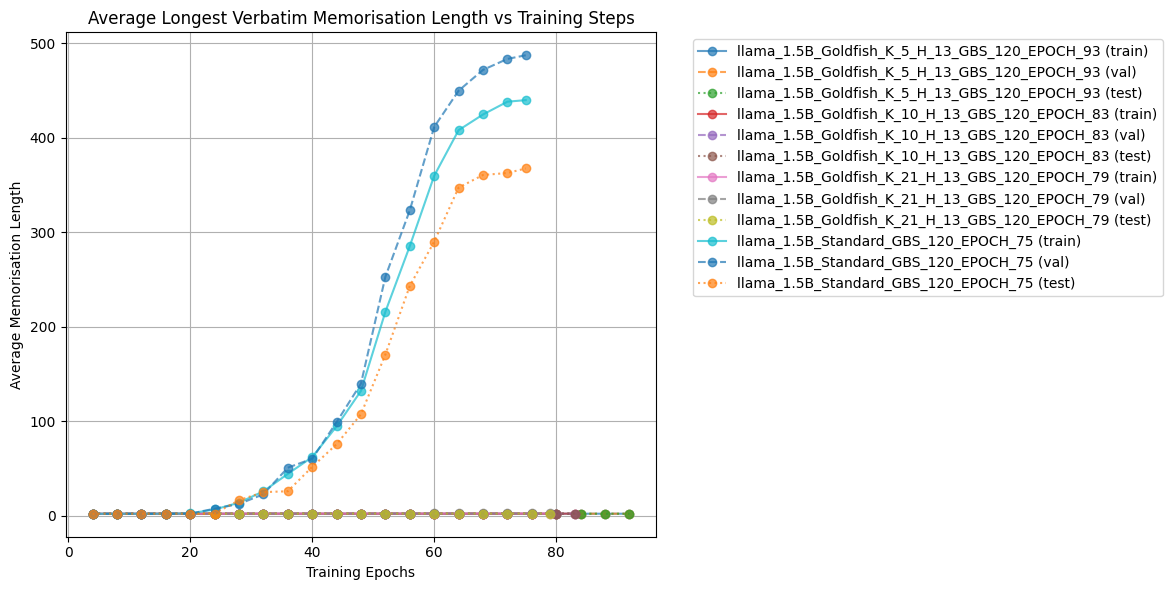

In [25]:
plot_comparison(results)

In [28]:
save_results(results, './avg_cs.pkl')

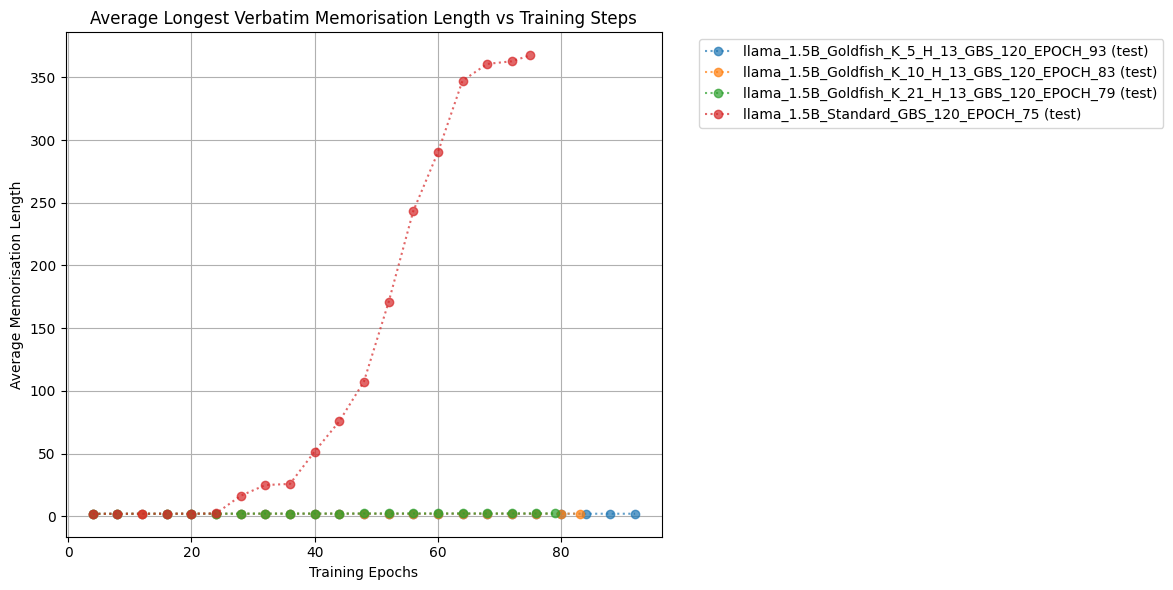

In [29]:
plot_comparison(results, exclude_splits=['train', 'val'])

In [45]:
def plot_comparison(results, include_ckpts=None, include_splits=None, title=None, log_y=False):
   """
   Plot comparison of models with train/val/test splits
   
   Parameters
   ----------
   results : dict
       Dictionary containing results for each model and split
   include_ckpts : list, optional
       List of model IDs to include in plotting. If None, includes all models.
   include_splits : list, optional
       List of split names to include in plotting. If None, includes all splits.
   title : str, optional
       Custom title for the plot. If None, uses default title.
   log_y : bool, optional
       Whether to use log scale for y-axis
       
   Examples
   --------
   >>> # Plot all models and splits
   >>> plot_comparison(results)
   
   >>> # Include only specific models and splits
   >>> plot_comparison(results, 
   ...                include_ckpts=['llama_1.5B_Standard'],
   ...                include_splits=['train', 'val'])
   
   >>> # Custom title and log scale
   >>> plot_comparison(results,
   ...                title='Model Comparison',
   ...                log_y=True)
   """
   plt.figure(figsize=(12, 6))
   
   # Line styles for different splits
   all_styles = {
       'train': '-',
       'val': '--',
       'test': ':'
   }
   
   # Filter splits to include
   styles = all_styles if include_splits is None else {
       k: v for k, v in all_styles.items() if k in include_splits
   }
   
   # Filter models and plot
   models_to_plot = results.keys() if include_ckpts is None else include_ckpts
   
   for model_name in models_to_plot:
       if model_name not in results:
           continue
           
       model_results = results[model_name]
       
       # Plot each included split
       for split_name, style in styles.items():
           split_data = model_results[split_name]
           
           # Convert steps to epochs
           epochs = [step/75 for step in split_data['steps']]
           
           plt.plot(epochs, split_data['avg_lengths'],
                   linestyle=style,
                   marker='o', 
                   label=f'{model_name} ({split_name})',
                   alpha=0.7)
   
   plt.xlabel('Training Epochs')
   plt.ylabel('Average Memorisation Length')
   
   # Use custom title if provided, otherwise use default
   plot_title = title if title else 'Average Longest Verbatim Memorisation Length vs Training Epochs'
   plt.title(plot_title)
   
   # Set y-axis to log scale if requested
   if log_y:
       plt.yscale('log')
   
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.grid(True)
   plt.tight_layout()
   
   plt.show()

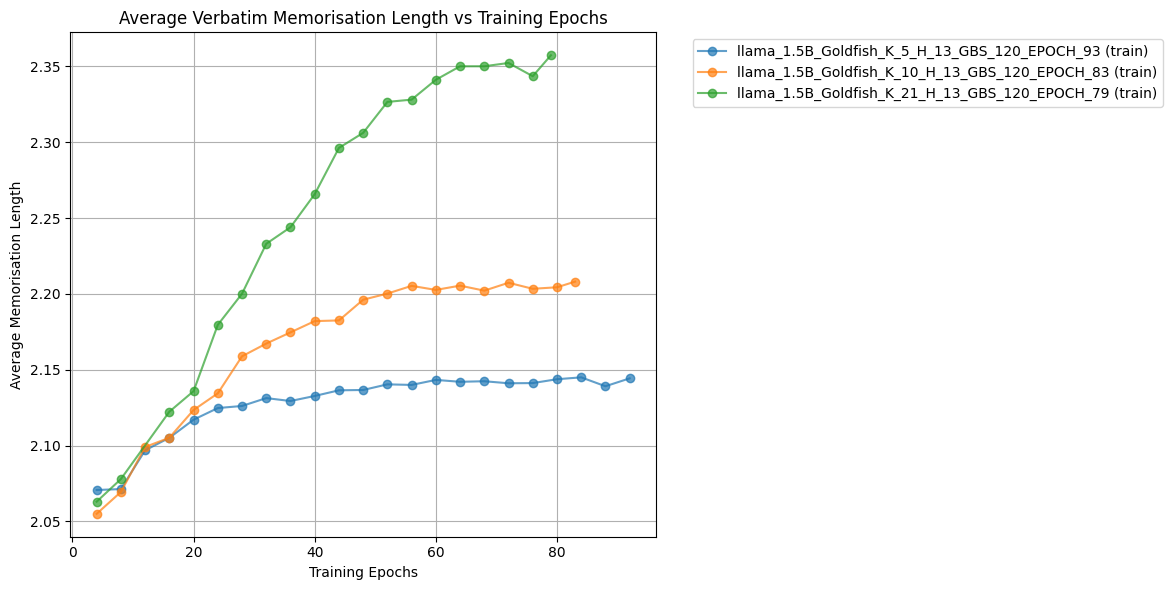

In [59]:
plot_comparison(
    results=results, 
    include_ckpts=[
        "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
        "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
        "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
        # "llama_1.5B_Standard_GBS_120_EPOCH_75"
    ], 
    include_splits=[
        'train', 
        # 'val', 
        # 'test'
    ],
    title='Average Verbatim Memorisation Length vs Training Epochs'
)

In [ ]:
# 